# Init

In [1]:
%matplotlib inline

import csv
import itertools
import math
import matplotlib
import time
import logging
import sys
import os
import random
import warnings

import gensim

import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path

from tqdm import tqdm_notebook as tqdm
from collections import Counter, defaultdict

from sklearn import random_projection
from sklearn.manifold import TSNE
from scipy.sparse import coo_matrix, csr_matrix, csc_matrix, spdiags
from scipy.io import loadmat, savemat
from sklearn.metrics import f1_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize, MultiLabelBinarizer

In [2]:
from sklearn import preprocessing

In [30]:
from scoring import scoring

In [4]:
# to ignore sklearn warning
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings("ignore", category=RuntimeWarning) 

In [5]:
%load_ext autoreload
%autoreload 2

# Load Data

## Blogcatalog

In [6]:
blogcatalog = loadmat('example_graphs/blogcatalog.mat')
blog_labels = blogcatalog['group']
blog_A = blogcatalog['network']
N = blog_A.shape[0]

In [7]:
blog_A

<10312x10312 sparse matrix of type '<class 'numpy.float64'>'
	with 667966 stored elements in Compressed Sparse Column format>

In [8]:
N

10312

In [9]:
d = [l[0] for l in blog_A.sum(axis=1).tolist()]

alpha=  1.258526391056572   sigma=  0.0025458536330247006


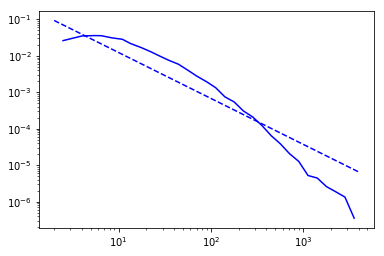

In [10]:
import powerlaw

fit = powerlaw.Fit(np.array(d)+1,xmin=1,discrete=True)
fit.power_law.plot_pdf( color= 'b',linestyle='--',label='fit ccdf')
fit.plot_pdf(color= 'b')

print('alpha= ',fit.power_law.alpha,'  sigma= ',fit.power_law.sigma)

# Random Projection

In [22]:
# projection method: choose from Gaussian and Sparse
# input matrix: choose from adjacency and transition matrix
# alpha adjusts the weighting of nodes according to their degree
def randne_projection(A, q=3, dim=128, projection_method='gaussian', input_matrix='adj', alpha=None):
    assert input_matrix == 'adj' or input_matrix == 'trans'
    assert projection_method == 'gaussian' or projection_method == 'sparse'
    
    if input_matrix == 'adj':
        M = A
    else:
        N = A.shape[0]
        normalizer = spdiags(np.squeeze(1.0 / csc_matrix.sum(A, axis=1) ), 0, N, N)
        M = normalizer @ A
        if alpha is not None:
            M = M.power(alpha)
    # Gaussian projection matrix
    if projection_method == 'gaussian':
        transformer = random_projection.GaussianRandomProjection(n_components=dim, random_state=42)
    # Sparse projection matrix
    else:
        transformer = random_projection.SparseRandomProjection(n_components=dim, random_state=42)
    Y = transformer.fit(M)
    # Random projection for A
#     if alpha is not None:
#         Y.components_ = Y.components_ @ spdiags( \
#                         np.squeeze(np.power(csc_matrix.sum(A, axis=1), alpha)), 0, N, N)
    cur_U = transformer.transform(M)
    U_list = [cur_U]
    
    for i in range(2, q + 1):
        cur_U = M @ cur_U
        U_list.append(cur_U)
    return U_list

In [23]:
# When weights is None, concatenate instead of linearly combines the embeddings from different powers of A
def randne_merge(U_list, weights, normalization=False):
    dense_U_list = [_U.todense() for _U in U_list] if type(U_list[0]) == csc_matrix else U_list
    _U_list = [normalize(_U, norm='l2', axis=1) for _U in dense_U_list] if normalization else dense_U_list

    if weights is None:
        return np.concatenate(_U_list, axis=1)
    U = np.zeros_like(_U_list[0])
    for cur_U, weight in zip(_U_list, weights):
        U += cur_U * weight
    U = preprocessing.scale(U.todense())
    # U = normalize(U.todense(), norm='l2', axis=1)
    return U

In [24]:
# A is always the adjacency matrix
# the choice between adj matrix and trans matrix is decided in the conf
def randne_wrapper(A, conf):
    U_list = randne_projection(A,
                               q=len(conf['weights']),
                               dim=conf['dim'],
                               projection_method=conf['projection_method'],
                               input_matrix=conf['input_matrix'],
                               alpha=conf['alpha'],
    )
    U = randne_merge(U_list, conf['weights'], conf['normalization'])
    return U

# Configuration for Easy Grid Search

In [32]:
def get_emb_filename(prefix, conf):
    return prefix + '-dim=' + str(conf['dim']) + ',projection_method=' + conf['projection_method'] \
        + ',input_matrix=' + conf['input_matrix'] + ',normalization=' + str(conf['normalization']) \
        + ',weights=' + (','.join(map(str, conf['weights'])) if conf['weights'] is not None else 'None') \
        + ',alpha=' + (str(conf['alpha']) if 'alpha' in conf else '') \
        + ',C=' + (str(conf['C']) if 'C' in conf else '1.0') \
        + '.mat'

# Intelligent Hyperparameter Search

In [26]:
import optuna

In [29]:
prefix = 'result/blog-p3'

In [33]:
%%time
order_range = 2
def objective(trial):

    # Invoke suggest methods of a Trial object to generate hyperparameters.
    weights = [trial.suggest_loguniform('weight' + str(order), 1.0, 64.0) for order in range(order_range)]
    alpha = trial.suggest_uniform('alpha', 0.5, 2.0)
    conf = {
        'projection_method': 'sparse',
        'input_matrix': 'trans',
        'weights': [1.0, 1.0] + weights,
        'normalization': True,
        'dim': 128,
        'alpha': alpha,
        'C': 0.1
    }
    emb_filename = get_emb_filename(prefix, conf)
    print (emb_filename)
    # first check if this file already exists
    path = Path(emb_filename)
    if not path.is_file():
        U = randne_wrapper(blog_A, conf)
        savemat(emb_filename, {'emb': U})
    else:
        print ('File %s already exists, skipped.' % emb_filename)
    f1_scores = scoring(
        [
            "--emb", emb_filename,
            "--network","example_graphs/blogcatalog.mat",
            "--num-shuffles", "3",
            "--debug",
            "--C", str(conf['C']),
            "--training-percents", "10",
        ]
    )
    # there should only be one entry here
    return -f1_scores[0]['micro']

study = optuna.create_study()  # Create a new study.
study.optimize(objective, n_trials=100)  # Invoke optimization of the objective function.

result/blog-p3-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,4.343825280082759,3.0779516748270903,alpha=0.8309612188492241,C=0.1.mat
Train percent: 0.1
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.1
Average score: {'micro': 0.3017328277188612, 'macro': 0.1660976243055171}
-------------------


[I 2019-05-10 21:14:02,497] Finished trial#0 resulted in value: -0.3017328277188612. Current best value is -0.3017328277188612 with parameters: {'weight0': 4.343825280082759, 'weight1': 3.0779516748270903, 'alpha': 0.8309612188492241}.


result/blog-p3-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,2.715208277289996,1.7973521680949531,alpha=1.5901807466469522,C=0.1.mat
Train percent: 0.1
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.1
Average score: {'micro': 0.3054110106656052, 'macro': 0.1766560559869107}
-------------------


[I 2019-05-10 21:14:06,356] Finished trial#1 resulted in value: -0.3054110106656052. Current best value is -0.3054110106656052 with parameters: {'weight0': 2.715208277289996, 'weight1': 1.7973521680949531, 'alpha': 1.5901807466469522}.


result/blog-p3-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,2.1655684225798355,38.09042072308096,alpha=1.921141747066078,C=0.1.mat
Train percent: 0.1
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.1
Average score: {'micro': 0.2681896737116701, 'macro': 0.15457580436702512}
-------------------


[I 2019-05-10 21:14:10,103] Finished trial#2 resulted in value: -0.2681896737116701. Current best value is -0.3054110106656052 with parameters: {'weight0': 2.715208277289996, 'weight1': 1.7973521680949531, 'alpha': 1.5901807466469522}.


result/blog-p3-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,7.3526312098324444,24.631217630972543,alpha=1.2365377837653584,C=0.1.mat
Train percent: 0.1
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.1
Average score: {'micro': 0.34694900927194133, 'macro': 0.20069111987808183}
-------------------


[I 2019-05-10 21:14:14,130] Finished trial#3 resulted in value: -0.34694900927194133. Current best value is -0.34694900927194133 with parameters: {'weight0': 7.3526312098324444, 'weight1': 24.631217630972543, 'alpha': 1.2365377837653584}.


result/blog-p3-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,15.662216459291976,25.03032984956006,alpha=1.9739950818803105,C=0.1.mat
Train percent: 0.1
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.1
Average score: {'micro': 0.2971224159535479, 'macro': 0.18180818855930067}
-------------------


[I 2019-05-10 21:14:17,705] Finished trial#4 resulted in value: -0.2971224159535479. Current best value is -0.34694900927194133 with parameters: {'weight0': 7.3526312098324444, 'weight1': 24.631217630972543, 'alpha': 1.2365377837653584}.


result/blog-p3-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,3.3317710872186215,54.79935512410411,alpha=1.3414214260906125,C=0.1.mat
Train percent: 0.1
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.1
Average score: {'micro': 0.3330519089447644, 'macro': 0.1799100034729213}
-------------------


[I 2019-05-10 21:14:21,641] Finished trial#5 resulted in value: -0.3330519089447644. Current best value is -0.34694900927194133 with parameters: {'weight0': 7.3526312098324444, 'weight1': 24.631217630972543, 'alpha': 1.2365377837653584}.


result/blog-p3-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,44.16711310643563,16.45166335184479,alpha=1.8883965465531944,C=0.1.mat
Train percent: 0.1
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.1
Average score: {'micro': 0.29760208356836776, 'macro': 0.17416414508688546}
-------------------


[I 2019-05-10 21:14:25,221] Finished trial#6 resulted in value: -0.29760208356836776. Current best value is -0.34694900927194133 with parameters: {'weight0': 7.3526312098324444, 'weight1': 24.631217630972543, 'alpha': 1.2365377837653584}.


result/blog-p3-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,6.8041353886426625,4.405115968002809,alpha=0.6638718474502528,C=0.1.mat
Train percent: 0.1
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.1
Average score: {'micro': 0.29470477569696724, 'macro': 0.15216064108243796}
-------------------


[I 2019-05-10 21:14:29,140] Finished trial#7 resulted in value: -0.29470477569696724. Current best value is -0.34694900927194133 with parameters: {'weight0': 7.3526312098324444, 'weight1': 24.631217630972543, 'alpha': 1.2365377837653584}.


result/blog-p3-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,12.239110244330066,1.4719705491587238,alpha=0.8509128742382231,C=0.1.mat
Train percent: 0.1
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.1
Average score: {'micro': 0.3115066032607738, 'macro': 0.16438287887543257}
-------------------


[I 2019-05-10 21:14:33,194] Finished trial#8 resulted in value: -0.3115066032607738. Current best value is -0.34694900927194133 with parameters: {'weight0': 7.3526312098324444, 'weight1': 24.631217630972543, 'alpha': 1.2365377837653584}.


result/blog-p3-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,1.9101323354774338,18.01753633712188,alpha=1.8192639427022637,C=0.1.mat
Train percent: 0.1
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.1
Average score: {'micro': 0.28399136265750174, 'macro': 0.15653335997062695}
-------------------


[I 2019-05-10 21:14:36,804] Finished trial#9 resulted in value: -0.28399136265750174. Current best value is -0.34694900927194133 with parameters: {'weight0': 7.3526312098324444, 'weight1': 24.631217630972543, 'alpha': 1.2365377837653584}.


result/blog-p3-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,21.70910575759229,7.122359658241392,alpha=1.1019985800193144,C=0.1.mat
Train percent: 0.1
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.1
Average score: {'micro': 0.3245682119792016, 'macro': 0.17498624576126295}
-------------------


[I 2019-05-10 21:14:40,804] Finished trial#10 resulted in value: -0.3245682119792016. Current best value is -0.34694900927194133 with parameters: {'weight0': 7.3526312098324444, 'weight1': 24.631217630972543, 'alpha': 1.2365377837653584}.


result/blog-p3-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,1.0288695064826183,9.108335155770858,alpha=1.2790103125907064,C=0.1.mat
Train percent: 0.1
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.1
Average score: {'micro': 0.32405222392705535, 'macro': 0.18092897339409042}
-------------------


[I 2019-05-10 21:14:44,796] Finished trial#11 resulted in value: -0.32405222392705535. Current best value is -0.34694900927194133 with parameters: {'weight0': 7.3526312098324444, 'weight1': 24.631217630972543, 'alpha': 1.2365377837653584}.


result/blog-p3-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,30.9856765974135,57.622240719644886,alpha=1.5246130812717662,C=0.1.mat
Train percent: 0.1
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.1
Average score: {'micro': 0.3344153343883233, 'macro': 0.19566172456723432}
-------------------


[I 2019-05-10 21:14:48,570] Finished trial#12 resulted in value: -0.3344153343883233. Current best value is -0.34694900927194133 with parameters: {'weight0': 7.3526312098324444, 'weight1': 24.631217630972543, 'alpha': 1.2365377837653584}.


result/blog-p3-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,6.664155325457374,9.992435503685424,alpha=1.0460248201494409,C=0.1.mat
Train percent: 0.1
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.1
Average score: {'micro': 0.3311458592230345, 'macro': 0.18158815335187395}
-------------------


[I 2019-05-10 21:14:52,420] Finished trial#13 resulted in value: -0.3311458592230345. Current best value is -0.34694900927194133 with parameters: {'weight0': 7.3526312098324444, 'weight1': 24.631217630972543, 'alpha': 1.2365377837653584}.


result/blog-p3-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,10.821964737148786,31.757681377418788,alpha=0.518704783827814,C=0.1.mat
Train percent: 0.1
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.1
Average score: {'micro': 0.318506225358877, 'macro': 0.15996695368242053}
-------------------


[I 2019-05-10 21:14:56,257] Finished trial#14 resulted in value: -0.318506225358877. Current best value is -0.34694900927194133 with parameters: {'weight0': 7.3526312098324444, 'weight1': 24.631217630972543, 'alpha': 1.2365377837653584}.


result/blog-p3-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,4.804888671547569,2.743097828639405,alpha=1.5948199146508828,C=0.1.mat
Train percent: 0.1
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.1
Average score: {'micro': 0.31253498956918446, 'macro': 0.18007770475974427}
-------------------


[I 2019-05-10 21:14:59,907] Finished trial#15 resulted in value: -0.31253498956918446. Current best value is -0.34694900927194133 with parameters: {'weight0': 7.3526312098324444, 'weight1': 24.631217630972543, 'alpha': 1.2365377837653584}.


result/blog-p3-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,1.4215092548014703,1.0251904332527877,alpha=1.1056585667080654,C=0.1.mat
Train percent: 0.1
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.1
Average score: {'micro': 0.2947081851957999, 'macro': 0.16528663036488003}
-------------------


[I 2019-05-10 21:15:03,408] Finished trial#16 resulted in value: -0.2947081851957999. Current best value is -0.34694900927194133 with parameters: {'weight0': 7.3526312098324444, 'weight1': 24.631217630972543, 'alpha': 1.2365377837653584}.


result/blog-p3-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,26.09329820110913,61.6819510335221,alpha=1.4595616737807176,C=0.1.mat
Train percent: 0.1
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.1
Average score: {'micro': 0.34231020444166355, 'macro': 0.2003790621626417}
-------------------


[I 2019-05-10 21:15:07,239] Finished trial#17 resulted in value: -0.34231020444166355. Current best value is -0.34694900927194133 with parameters: {'weight0': 7.3526312098324444, 'weight1': 24.631217630972543, 'alpha': 1.2365377837653584}.


result/blog-p3-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,24.652029606044,62.38784755935806,alpha=1.4859358295698266,C=0.1.mat
Train percent: 0.1
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.1
Average score: {'micro': 0.33780330543071546, 'macro': 0.19556101916746202}
-------------------


[I 2019-05-10 21:15:11,051] Finished trial#18 resulted in value: -0.33780330543071546. Current best value is -0.34694900927194133 with parameters: {'weight0': 7.3526312098324444, 'weight1': 24.631217630972543, 'alpha': 1.2365377837653584}.


result/blog-p3-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,44.18071266041972,40.804030063569606,alpha=1.7082615056658697,C=0.1.mat
Train percent: 0.1
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.1
Average score: {'micro': 0.3186187754214114, 'macro': 0.18727878169004017}
-------------------


[I 2019-05-10 21:15:14,678] Finished trial#19 resulted in value: -0.3186187754214114. Current best value is -0.34694900927194133 with parameters: {'weight0': 7.3526312098324444, 'weight1': 24.631217630972543, 'alpha': 1.2365377837653584}.


result/blog-p3-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,16.68246469082191,18.36711023863032,alpha=1.374489213113179,C=0.1.mat
Train percent: 0.1
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.1
Average score: {'micro': 0.33324640029559366, 'macro': 0.19122047279014973}
-------------------


[I 2019-05-10 21:15:18,515] Finished trial#20 resulted in value: -0.33324640029559366. Current best value is -0.34694900927194133 with parameters: {'weight0': 7.3526312098324444, 'weight1': 24.631217630972543, 'alpha': 1.2365377837653584}.


result/blog-p3-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,9.42738505769309,25.60970657150698,alpha=1.1717647554737072,C=0.1.mat
Train percent: 0.1
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.1
Average score: {'micro': 0.34223425593632867, 'macro': 0.18831020843615928}
-------------------


[I 2019-05-10 21:15:22,513] Finished trial#21 resulted in value: -0.34223425593632867. Current best value is -0.34694900927194133 with parameters: {'weight0': 7.3526312098324444, 'weight1': 24.631217630972543, 'alpha': 1.2365377837653584}.


result/blog-p3-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,58.25953631846226,12.932824435093584,alpha=0.9430934318260009,C=0.1.mat
Train percent: 0.1
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.1
Average score: {'micro': 0.32848447443129886, 'macro': 0.1723302628992284}
-------------------


[I 2019-05-10 21:15:26,311] Finished trial#22 resulted in value: -0.32848447443129886. Current best value is -0.34694900927194133 with parameters: {'weight0': 7.3526312098324444, 'weight1': 24.631217630972543, 'alpha': 1.2365377837653584}.


result/blog-p3-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,35.37475294344698,44.28310356694814,alpha=1.3871872189289376,C=0.1.mat
Train percent: 0.1
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.1
Average score: {'micro': 0.3337471842387481, 'macro': 0.1924820860391393}
-------------------


[I 2019-05-10 21:15:29,989] Finished trial#23 resulted in value: -0.3337471842387481. Current best value is -0.34694900927194133 with parameters: {'weight0': 7.3526312098324444, 'weight1': 24.631217630972543, 'alpha': 1.2365377837653584}.


result/blog-p3-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,17.005680053029575,26.76058810920505,alpha=1.721433351553261,C=0.1.mat
Train percent: 0.1
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.1
Average score: {'micro': 0.3179737101329978, 'macro': 0.18222119363600442}
-------------------


[I 2019-05-10 21:15:33,397] Finished trial#24 resulted in value: -0.3179737101329978. Current best value is -0.34694900927194133 with parameters: {'weight0': 7.3526312098324444, 'weight1': 24.631217630972543, 'alpha': 1.2365377837653584}.


result/blog-p3-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,4.895437789817071,6.469673314073566,alpha=1.2149319687861055,C=0.1.mat
Train percent: 0.1
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.1
Average score: {'micro': 0.3265502343774309, 'macro': 0.1850053027943491}
-------------------


[I 2019-05-10 21:15:37,285] Finished trial#25 resulted in value: -0.3265502343774309. Current best value is -0.34694900927194133 with parameters: {'weight0': 7.3526312098324444, 'weight1': 24.631217630972543, 'alpha': 1.2365377837653584}.


result/blog-p3-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,8.478760001864478,62.012102210968884,alpha=0.6867473362142021,C=0.1.mat
Train percent: 0.1
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.1
Average score: {'micro': 0.3304359497572649, 'macro': 0.16380825435609528}
-------------------


[I 2019-05-10 21:15:41,475] Finished trial#26 resulted in value: -0.3304359497572649. Current best value is -0.34694900927194133 with parameters: {'weight0': 7.3526312098324444, 'weight1': 24.631217630972543, 'alpha': 1.2365377837653584}.


result/blog-p3-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,13.006654923451602,11.786364435251084,alpha=1.4779605186973244,C=0.1.mat
Train percent: 0.1
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.1
Average score: {'micro': 0.32504011609291666, 'macro': 0.18966409754230099}
-------------------


[I 2019-05-10 21:15:45,058] Finished trial#27 resulted in value: -0.32504011609291666. Current best value is -0.34694900927194133 with parameters: {'weight0': 7.3526312098324444, 'weight1': 24.631217630972543, 'alpha': 1.2365377837653584}.


result/blog-p3-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,22.365546810187027,5.165797818658115,alpha=0.9584841174890405,C=0.1.mat
Train percent: 0.1
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.1
Average score: {'micro': 0.31806164158001, 'macro': 0.1638201203358638}
-------------------


[I 2019-05-10 21:15:48,996] Finished trial#28 resulted in value: -0.31806164158001. Current best value is -0.34694900927194133 with parameters: {'weight0': 7.3526312098324444, 'weight1': 24.631217630972543, 'alpha': 1.2365377837653584}.


result/blog-p3-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,6.242351878255998,20.29753009417828,alpha=1.6930691883964144,C=0.1.mat
Train percent: 0.1
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.1
Average score: {'micro': 0.3118505513745799, 'macro': 0.1788102942578038}
-------------------


[I 2019-05-10 21:15:52,678] Finished trial#29 resulted in value: -0.3118505513745799. Current best value is -0.34694900927194133 with parameters: {'weight0': 7.3526312098324444, 'weight1': 24.631217630972543, 'alpha': 1.2365377837653584}.


result/blog-p3-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,3.6360508686413167,34.63701189395725,alpha=1.278418418044638,C=0.1.mat
Train percent: 0.1
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.1
Average score: {'micro': 0.3401863124445524, 'macro': 0.19082515568533123}
-------------------


[I 2019-05-10 21:15:56,515] Finished trial#30 resulted in value: -0.3401863124445524. Current best value is -0.34694900927194133 with parameters: {'weight0': 7.3526312098324444, 'weight1': 24.631217630972543, 'alpha': 1.2365377837653584}.


result/blog-p3-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,28.303085671435593,46.913937937746056,alpha=1.612490731758406,C=0.1.mat
Train percent: 0.1
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.1
Average score: {'micro': 0.32281235055156565, 'macro': 0.19392644311622786}
-------------------


[I 2019-05-10 21:16:00,502] Finished trial#31 resulted in value: -0.32281235055156565. Current best value is -0.34694900927194133 with parameters: {'weight0': 7.3526312098324444, 'weight1': 24.631217630972543, 'alpha': 1.2365377837653584}.


result/blog-p3-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,42.76935215709639,13.194909617120778,alpha=0.6569737157539215,C=0.1.mat
Train percent: 0.1
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.1
Average score: {'micro': 0.3185481391035199, 'macro': 0.1559463008126296}
-------------------


[I 2019-05-10 21:16:04,628] Finished trial#32 resulted in value: -0.3185481391035199. Current best value is -0.34694900927194133 with parameters: {'weight0': 7.3526312098324444, 'weight1': 24.631217630972543, 'alpha': 1.2365377837653584}.


result/blog-p3-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,19.319522197886144,33.769311169669415,alpha=1.4106858989561,C=0.1.mat
Train percent: 0.1
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.1
Average score: {'micro': 0.3365049543629492, 'macro': 0.1851622673331811}
-------------------


[I 2019-05-10 21:16:08,411] Finished trial#33 resulted in value: -0.3365049543629492. Current best value is -0.34694900927194133 with parameters: {'weight0': 7.3526312098324444, 'weight1': 24.631217630972543, 'alpha': 1.2365377837653584}.


result/blog-p3-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,2.562557012122181,22.532438297799,alpha=1.8159658587663778,C=0.1.mat
Train percent: 0.1
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.1
Average score: {'micro': 0.2841593419938535, 'macro': 0.16294992196276323}
-------------------


[I 2019-05-10 21:16:11,993] Finished trial#34 resulted in value: -0.2841593419938535. Current best value is -0.34694900927194133 with parameters: {'weight0': 7.3526312098324444, 'weight1': 24.631217630972543, 'alpha': 1.2365377837653584}.


result/blog-p3-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,3.478449774117821,3.306606825457,alpha=1.00471665635097,C=0.1.mat
Train percent: 0.1
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.1
Average score: {'micro': 0.3105613569573555, 'macro': 0.16863090733269445}
-------------------


[I 2019-05-10 21:16:15,619] Finished trial#35 resulted in value: -0.3105613569573555. Current best value is -0.34694900927194133 with parameters: {'weight0': 7.3526312098324444, 'weight1': 24.631217630972543, 'alpha': 1.2365377837653584}.


result/blog-p3-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,13.83555686043346,14.787651142776173,alpha=0.8239500178884533,C=0.1.mat
Train percent: 0.1
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.1
Average score: {'micro': 0.32372285300473963, 'macro': 0.16788394806798648}
-------------------


[I 2019-05-10 21:16:19,695] Finished trial#36 resulted in value: -0.32372285300473963. Current best value is -0.34694900927194133 with parameters: {'weight0': 7.3526312098324444, 'weight1': 24.631217630972543, 'alpha': 1.2365377837653584}.


result/blog-p3-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,10.405329677611485,49.939843307504404,alpha=1.1527164553210032,C=0.1.mat
Train percent: 0.1
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.1
Average score: {'micro': 0.34943492142259763, 'macro': 0.19028525351881775}
-------------------


[I 2019-05-10 21:16:23,665] Finished trial#37 resulted in value: -0.34943492142259763. Current best value is -0.34943492142259763 with parameters: {'weight0': 10.405329677611485, 'weight1': 49.939843307504404, 'alpha': 1.1527164553210032}.


result/blog-p3-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,1.4522409304123682,30.533799757271932,alpha=0.8223904409024847,C=0.1.mat
Train percent: 0.1
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.1
Average score: {'micro': 0.3340094494897703, 'macro': 0.17804896726179595}
-------------------


[I 2019-05-10 21:16:27,787] Finished trial#38 resulted in value: -0.3340094494897703. Current best value is -0.34943492142259763 with parameters: {'weight0': 10.405329677611485, 'weight1': 49.939843307504404, 'alpha': 1.1527164553210032}.


result/blog-p3-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,2.6007198801194926,47.89772926999167,alpha=1.1588014866669076,C=0.1.mat
Train percent: 0.1
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.1
Average score: {'micro': 0.34895633230226686, 'macro': 0.19013961908262747}
-------------------


[I 2019-05-10 21:16:31,799] Finished trial#39 resulted in value: -0.34895633230226686. Current best value is -0.34943492142259763 with parameters: {'weight0': 10.405329677611485, 'weight1': 49.939843307504404, 'alpha': 1.1527164553210032}.


result/blog-p3-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,1.7723101352825876,1.8033526715881891,alpha=0.8871598901838187,C=0.1.mat
Train percent: 0.1
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.1
Average score: {'micro': 0.29087526498013755, 'macro': 0.1663243149746423}
-------------------


[I 2019-05-10 21:16:35,640] Finished trial#40 resulted in value: -0.29087526498013755. Current best value is -0.34943492142259763 with parameters: {'weight0': 10.405329677611485, 'weight1': 49.939843307504404, 'alpha': 1.1527164553210032}.


result/blog-p3-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,2.425801446206998,46.1462735905142,alpha=1.1332749758368044,C=0.1.mat
Train percent: 0.1
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.1
Average score: {'micro': 0.35014660254551505, 'macro': 0.18815888952136064}
-------------------


[I 2019-05-10 21:16:39,698] Finished trial#41 resulted in value: -0.35014660254551505. Current best value is -0.35014660254551505 with parameters: {'weight0': 2.425801446206998, 'weight1': 46.1462735905142, 'alpha': 1.1332749758368044}.


result/blog-p3-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,1.2497302692590326,1.270877796091401,alpha=0.7495025643802631,C=0.1.mat
Train percent: 0.1
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.1
Average score: {'micro': 0.2798936616215588, 'macro': 0.1531302070405727}
-------------------


[I 2019-05-10 21:16:43,438] Finished trial#42 resulted in value: -0.2798936616215588. Current best value is -0.35014660254551505 with parameters: {'weight0': 2.425801446206998, 'weight1': 46.1462735905142, 'alpha': 1.1332749758368044}.


result/blog-p3-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,5.157673187625167,49.47307629601228,alpha=1.2980744992087827,C=0.1.mat
Train percent: 0.1
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.1
Average score: {'micro': 0.3427326020937153, 'macro': 0.19148774196881957}
-------------------


[I 2019-05-10 21:16:47,493] Finished trial#43 resulted in value: -0.3427326020937153. Current best value is -0.35014660254551505 with parameters: {'weight0': 2.425801446206998, 'weight1': 46.1462735905142, 'alpha': 1.1332749758368044}.


result/blog-p3-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,2.072034388536685,37.09722045016613,alpha=1.034901420730345,C=0.1.mat
Train percent: 0.1
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.1
Average score: {'micro': 0.34298452748745173, 'macro': 0.18571444016267732}
-------------------


[I 2019-05-10 21:16:51,435] Finished trial#44 resulted in value: -0.34298452748745173. Current best value is -0.35014660254551505 with parameters: {'weight0': 2.425801446206998, 'weight1': 46.1462735905142, 'alpha': 1.1332749758368044}.


result/blog-p3-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,4.027452514576318,10.244060541265224,alpha=1.1142915465992593,C=0.1.mat
Train percent: 0.1
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.1
Average score: {'micro': 0.3281396329566141, 'macro': 0.19001957146897688}
-------------------


[I 2019-05-10 21:16:55,472] Finished trial#45 resulted in value: -0.3281396329566141. Current best value is -0.35014660254551505 with parameters: {'weight0': 2.425801446206998, 'weight1': 46.1462735905142, 'alpha': 1.1332749758368044}.


result/blog-p3-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,3.004141157317226,8.166358220633006,alpha=0.7488382413572151,C=0.1.mat
Train percent: 0.1
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.1
Average score: {'micro': 0.3053351996666575, 'macro': 0.16529153519270526}
-------------------


[I 2019-05-10 21:16:59,089] Finished trial#46 resulted in value: -0.3053351996666575. Current best value is -0.35014660254551505 with parameters: {'weight0': 2.425801446206998, 'weight1': 46.1462735905142, 'alpha': 1.1332749758368044}.


result/blog-p3-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,5.516705331026378,2.3446589074904476,alpha=1.3299710016883277,C=0.1.mat
Train percent: 0.1
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.1
Average score: {'micro': 0.3166615023303048, 'macro': 0.17917891448617848}
-------------------


[I 2019-05-10 21:17:03,029] Finished trial#47 resulted in value: -0.3166615023303048. Current best value is -0.35014660254551505 with parameters: {'weight0': 2.425801446206998, 'weight1': 46.1462735905142, 'alpha': 1.1332749758368044}.


result/blog-p3-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,10.73907416412333,4.288671459985084,alpha=1.2216314989350923,C=0.1.mat
Train percent: 0.1
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.1
Average score: {'micro': 0.32260921175524154, 'macro': 0.1770662347685101}
-------------------


[I 2019-05-10 21:17:06,818] Finished trial#48 resulted in value: -0.32260921175524154. Current best value is -0.35014660254551505 with parameters: {'weight0': 2.425801446206998, 'weight1': 46.1462735905142, 'alpha': 1.1332749758368044}.


result/blog-p3-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,1.5773743029628646,16.945094789361356,alpha=0.6245761456287837,C=0.1.mat
Train percent: 0.1
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.1
Average score: {'micro': 0.30426043877339953, 'macro': 0.15890590246858818}
-------------------


[I 2019-05-10 21:17:10,586] Finished trial#49 resulted in value: -0.30426043877339953. Current best value is -0.35014660254551505 with parameters: {'weight0': 2.425801446206998, 'weight1': 46.1462735905142, 'alpha': 1.1332749758368044}.


result/blog-p3-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,7.590468888063755,27.645643990299938,alpha=0.9111131483461934,C=0.1.mat
Train percent: 0.1
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.1
Average score: {'micro': 0.33881270187521273, 'macro': 0.18448309084497905}
-------------------


[I 2019-05-10 21:17:14,539] Finished trial#50 resulted in value: -0.33881270187521273. Current best value is -0.35014660254551505 with parameters: {'weight0': 2.425801446206998, 'weight1': 46.1462735905142, 'alpha': 1.1332749758368044}.


result/blog-p3-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,1.1002740976885133,22.06017204657318,alpha=0.5605873362159604,C=0.1.mat
Train percent: 0.1
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.1
Average score: {'micro': 0.29490177889283253, 'macro': 0.1481809155269368}
-------------------


[I 2019-05-10 21:17:18,380] Finished trial#51 resulted in value: -0.29490177889283253. Current best value is -0.35014660254551505 with parameters: {'weight0': 2.425801446206998, 'weight1': 46.1462735905142, 'alpha': 1.1332749758368044}.


result/blog-p3-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,2.334582069135292,54.353995619706076,alpha=1.0832857695627378,C=0.1.mat
Train percent: 0.1
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.1
Average score: {'micro': 0.3451285830953143, 'macro': 0.1863537086899665}
-------------------


[I 2019-05-10 21:17:22,296] Finished trial#52 resulted in value: -0.3451285830953143. Current best value is -0.35014660254551505 with parameters: {'weight0': 2.425801446206998, 'weight1': 46.1462735905142, 'alpha': 1.1332749758368044}.


result/blog-p3-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,4.0566449596677145,6.2569680859783094,alpha=1.1504461754256214,C=0.1.mat
Train percent: 0.1
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.1
Average score: {'micro': 0.3230962476532269, 'macro': 0.18285674480995903}
-------------------


[I 2019-05-10 21:17:26,118] Finished trial#53 resulted in value: -0.3230962476532269. Current best value is -0.35014660254551505 with parameters: {'weight0': 2.425801446206998, 'weight1': 46.1462735905142, 'alpha': 1.1332749758368044}.


result/blog-p3-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,9.072965705389633,40.119900486738196,alpha=0.9871061620799971,C=0.1.mat
Train percent: 0.1
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.1
Average score: {'micro': 0.3467229843021034, 'macro': 0.18818434776215956}
-------------------


[I 2019-05-10 21:17:30,041] Finished trial#54 resulted in value: -0.3467229843021034. Current best value is -0.35014660254551505 with parameters: {'weight0': 2.425801446206998, 'weight1': 46.1462735905142, 'alpha': 1.1332749758368044}.


result/blog-p3-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,2.9921925402491856,14.994938855644406,alpha=1.5297911638571002,C=0.1.mat
Train percent: 0.1
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.1
Average score: {'micro': 0.31886084521749947, 'macro': 0.17956265707007524}
-------------------


[I 2019-05-10 21:17:33,678] Finished trial#55 resulted in value: -0.31886084521749947. Current best value is -0.35014660254551505 with parameters: {'weight0': 2.425801446206998, 'weight1': 46.1462735905142, 'alpha': 1.1332749758368044}.


result/blog-p3-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,10.825817169695096,29.399412950312872,alpha=1.973762232291959,C=0.1.mat
Train percent: 0.1
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.1
Average score: {'micro': 0.28727458029516445, 'macro': 0.1697163908357764}
-------------------


[I 2019-05-10 21:17:37,323] Finished trial#56 resulted in value: -0.28727458029516445. Current best value is -0.35014660254551505 with parameters: {'weight0': 2.425801446206998, 'weight1': 46.1462735905142, 'alpha': 1.1332749758368044}.


result/blog-p3-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,6.117736801780961,19.28435621815147,alpha=1.417177982633365,C=0.1.mat
Train percent: 0.1
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.1
Average score: {'micro': 0.33568399931588533, 'macro': 0.19224773071848297}
-------------------


[I 2019-05-10 21:17:40,854] Finished trial#57 resulted in value: -0.33568399931588533. Current best value is -0.35014660254551505 with parameters: {'weight0': 2.425801446206998, 'weight1': 46.1462735905142, 'alpha': 1.1332749758368044}.


result/blog-p3-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,7.182887977989942,56.21936139130548,alpha=1.6365970494719306,C=0.1.mat
Train percent: 0.1
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.1
Average score: {'micro': 0.30455248678568325, 'macro': 0.1732609570038863}
-------------------


[I 2019-05-10 21:17:44,948] Finished trial#58 resulted in value: -0.30455248678568325. Current best value is -0.35014660254551505 with parameters: {'weight0': 2.425801446206998, 'weight1': 46.1462735905142, 'alpha': 1.1332749758368044}.


result/blog-p3-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,14.458048598869517,11.383335792476842,alpha=1.5301682057013801,C=0.1.mat
Train percent: 0.1
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.1
Average score: {'micro': 0.325797645375825, 'macro': 0.1925170963979103}
-------------------


[I 2019-05-10 21:17:48,618] Finished trial#59 resulted in value: -0.325797645375825. Current best value is -0.35014660254551505 with parameters: {'weight0': 2.425801446206998, 'weight1': 46.1462735905142, 'alpha': 1.1332749758368044}.


result/blog-p3-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,19.429313159653205,8.690534112710521,alpha=1.2012594249063864,C=0.1.mat
Train percent: 0.1
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.1
Average score: {'micro': 0.32595120771988495, 'macro': 0.18156814610676753}
-------------------


[I 2019-05-10 21:17:52,511] Finished trial#60 resulted in value: -0.32595120771988495. Current best value is -0.35014660254551505 with parameters: {'weight0': 2.425801446206998, 'weight1': 46.1462735905142, 'alpha': 1.1332749758368044}.


result/blog-p3-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,1.0353049162606056,23.56047641032199,alpha=1.7988209831596005,C=0.1.mat
Train percent: 0.1
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.1
Average score: {'micro': 0.2870008472384182, 'macro': 0.16445473525480375}
-------------------


[I 2019-05-10 21:17:56,085] Finished trial#61 resulted in value: -0.2870008472384182. Current best value is -0.35014660254551505 with parameters: {'weight0': 2.425801446206998, 'weight1': 46.1462735905142, 'alpha': 1.1332749758368044}.


result/blog-p3-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,1.844398218083128,6.979812641046972,alpha=0.7703783956882841,C=0.1.mat
Train percent: 0.1
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.1
Average score: {'micro': 0.29936503031490064, 'macro': 0.16222228344467612}
-------------------


[I 2019-05-10 21:17:59,748] Finished trial#62 resulted in value: -0.29936503031490064. Current best value is -0.35014660254551505 with parameters: {'weight0': 2.425801446206998, 'weight1': 46.1462735905142, 'alpha': 1.1332749758368044}.


result/blog-p3-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,63.6308286424027,63.21726494188201,alpha=1.3397154419530626,C=0.1.mat
Train percent: 0.1
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.1
Average score: {'micro': 0.33859369526925803, 'macro': 0.19246344135152774}
-------------------


[I 2019-05-10 21:18:03,663] Finished trial#63 resulted in value: -0.33859369526925803. Current best value is -0.35014660254551505 with parameters: {'weight0': 2.425801446206998, 'weight1': 46.1462735905142, 'alpha': 1.1332749758368044}.


result/blog-p3-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,34.6125937471299,42.343962742886625,alpha=1.0574934765897201,C=0.1.mat
Train percent: 0.1
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.1
Average score: {'micro': 0.3451103514295899, 'macro': 0.1877612309578914}
-------------------


[I 2019-05-10 21:18:07,440] Finished trial#64 resulted in value: -0.3451103514295899. Current best value is -0.35014660254551505 with parameters: {'weight0': 2.425801446206998, 'weight1': 46.1462735905142, 'alpha': 1.1332749758368044}.


result/blog-p3-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,2.5217131751610062,49.77433628530836,alpha=1.1425183858134162,C=0.1.mat
Train percent: 0.1
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.1
Average score: {'micro': 0.3473625227072313, 'macro': 0.1871689593852812}
-------------------


[I 2019-05-10 21:18:11,631] Finished trial#65 resulted in value: -0.3473625227072313. Current best value is -0.35014660254551505 with parameters: {'weight0': 2.425801446206998, 'weight1': 46.1462735905142, 'alpha': 1.1332749758368044}.


result/blog-p3-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,4.611399304259134,36.48304891889297,alpha=1.261226099846074,C=0.1.mat
Train percent: 0.1
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.1
Average score: {'micro': 0.34141332564515664, 'macro': 0.18848533117856903}
-------------------


[I 2019-05-10 21:18:15,544] Finished trial#66 resulted in value: -0.34141332564515664. Current best value is -0.35014660254551505 with parameters: {'weight0': 2.425801446206998, 'weight1': 46.1462735905142, 'alpha': 1.1332749758368044}.


result/blog-p3-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,3.0552872582149417,54.129024054069376,alpha=1.177745267345907,C=0.1.mat
Train percent: 0.1
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.1
Average score: {'micro': 0.346774565396409, 'macro': 0.18917289608761031}
-------------------


[I 2019-05-10 21:18:19,497] Finished trial#67 resulted in value: -0.346774565396409. Current best value is -0.35014660254551505 with parameters: {'weight0': 2.425801446206998, 'weight1': 46.1462735905142, 'alpha': 1.1332749758368044}.


result/blog-p3-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,1.2219500636787903,46.037873665685964,alpha=0.9151596567700444,C=0.1.mat
Train percent: 0.1
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.1
Average score: {'micro': 0.34479727175740216, 'macro': 0.18405731174676535}
-------------------


[I 2019-05-10 21:18:23,685] Finished trial#68 resulted in value: -0.34479727175740216. Current best value is -0.35014660254551505 with parameters: {'weight0': 2.425801446206998, 'weight1': 46.1462735905142, 'alpha': 1.1332749758368044}.


result/blog-p3-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,2.061007693601937,30.95418839000335,alpha=0.8687985191073447,C=0.1.mat
Train percent: 0.1
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.1
Average score: {'micro': 0.3311042799666087, 'macro': 0.17281100075811215}
-------------------


[I 2019-05-10 21:18:27,691] Finished trial#69 resulted in value: -0.3311042799666087. Current best value is -0.35014660254551505 with parameters: {'weight0': 2.425801446206998, 'weight1': 46.1462735905142, 'alpha': 1.1332749758368044}.


result/blog-p3-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,11.391589242776233,25.510479709514453,alpha=1.0312197046872646,C=0.1.mat
Train percent: 0.1
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.1
Average score: {'micro': 0.33898645748789913, 'macro': 0.1857712180161071}
-------------------


[I 2019-05-10 21:18:31,719] Finished trial#70 resulted in value: -0.33898645748789913. Current best value is -0.35014660254551505 with parameters: {'weight0': 2.425801446206998, 'weight1': 46.1462735905142, 'alpha': 1.1332749758368044}.


result/blog-p3-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,5.810417769544161,39.84138976034699,alpha=1.4408749567271824,C=0.1.mat
Train percent: 0.1
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.1
Average score: {'micro': 0.3242119423211951, 'macro': 0.17674897317588475}
-------------------


[I 2019-05-10 21:18:35,657] Finished trial#71 resulted in value: -0.3242119423211951. Current best value is -0.35014660254551505 with parameters: {'weight0': 2.425801446206998, 'weight1': 46.1462735905142, 'alpha': 1.1332749758368044}.


result/blog-p3-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,1.6300464680511988,20.090686786534263,alpha=0.9656820684719799,C=0.1.mat
Train percent: 0.1
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.1
Average score: {'micro': 0.3291961260101783, 'macro': 0.18076127519370777}
-------------------


[I 2019-05-10 21:18:39,782] Finished trial#72 resulted in value: -0.3291961260101783. Current best value is -0.35014660254551505 with parameters: {'weight0': 2.425801446206998, 'weight1': 46.1462735905142, 'alpha': 1.1332749758368044}.


result/blog-p3-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,7.917258426277186,63.32572839353798,alpha=1.3105810774941609,C=0.1.mat
Train percent: 0.1
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.1
Average score: {'micro': 0.3409653057376337, 'macro': 0.18537885748319505}
-------------------


[I 2019-05-10 21:18:43,924] Finished trial#73 resulted in value: -0.3409653057376337. Current best value is -0.35014660254551505 with parameters: {'weight0': 2.425801446206998, 'weight1': 46.1462735905142, 'alpha': 1.1332749758368044}.


result/blog-p3-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,3.7500292505407637,33.234148402051304,alpha=1.0882625798595547,C=0.1.mat
Train percent: 0.1
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.1
Average score: {'micro': 0.34093069072783444, 'macro': 0.18685802342567137}
-------------------


[I 2019-05-10 21:18:48,046] Finished trial#74 resulted in value: -0.34093069072783444. Current best value is -0.35014660254551505 with parameters: {'weight0': 2.425801446206998, 'weight1': 46.1462735905142, 'alpha': 1.1332749758368044}.


result/blog-p3-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,2.326787788750239,14.834899268588043,alpha=1.3719932810686244,C=0.1.mat
Train percent: 0.1
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.1
Average score: {'micro': 0.3272157307999372, 'macro': 0.18478827422670585}
-------------------


[I 2019-05-10 21:18:51,984] Finished trial#75 resulted in value: -0.3272157307999372. Current best value is -0.35014660254551505 with parameters: {'weight0': 2.425801446206998, 'weight1': 46.1462735905142, 'alpha': 1.1332749758368044}.


result/blog-p3-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,9.179108204281743,48.809903308958326,alpha=1.1317089738469925,C=0.1.mat
Train percent: 0.1
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.1
Average score: {'micro': 0.3503718141204069, 'macro': 0.19539778565679866}
-------------------


[I 2019-05-10 21:18:55,960] Finished trial#76 resulted in value: -0.3503718141204069. Current best value is -0.3503718141204069 with parameters: {'weight0': 9.179108204281743, 'weight1': 48.809903308958326, 'alpha': 1.1317089738469925}.


result/blog-p3-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,17.67316022553909,5.015482786076916,alpha=0.7988370566116354,C=0.1.mat
Train percent: 0.1
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.1
Average score: {'micro': 0.3151587827522429, 'macro': 0.1633614815068949}
-------------------


[I 2019-05-10 21:18:59,816] Finished trial#77 resulted in value: -0.3151587827522429. Current best value is -0.3503718141204069 with parameters: {'weight0': 9.179108204281743, 'weight1': 48.809903308958326, 'alpha': 1.1317089738469925}.


result/blog-p3-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,9.167095741854254,28.33288946674325,alpha=1.2516668338130363,C=0.1.mat
Train percent: 0.1
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.1
Average score: {'micro': 0.3455732182603475, 'macro': 0.1945709193395555}
-------------------


[I 2019-05-10 21:19:03,700] Finished trial#78 resulted in value: -0.3455732182603475. Current best value is -0.3503718141204069 with parameters: {'weight0': 9.179108204281743, 'weight1': 48.809903308958326, 'alpha': 1.1317089738469925}.


result/blog-p3-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,52.34717003640582,21.95803106396385,alpha=1.0133531725741618,C=0.1.mat
Train percent: 0.1
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.1
Average score: {'micro': 0.3310238244366562, 'macro': 0.1803924387565163}
-------------------


[I 2019-05-10 21:19:07,566] Finished trial#79 resulted in value: -0.3310238244366562. Current best value is -0.3503718141204069 with parameters: {'weight0': 9.179108204281743, 'weight1': 48.809903308958326, 'alpha': 1.1317089738469925}.


result/blog-p3-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,4.339234532599033,3.379029958411636,alpha=1.5540687938685507,C=0.1.mat
Train percent: 0.1
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.1
Average score: {'micro': 0.31417793648728404, 'macro': 0.18129787473332581}
-------------------


[I 2019-05-10 21:19:11,349] Finished trial#80 resulted in value: -0.31417793648728404. Current best value is -0.3503718141204069 with parameters: {'weight0': 9.179108204281743, 'weight1': 48.809903308958326, 'alpha': 1.1317089738469925}.


result/blog-p3-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,12.061854854153735,17.7801846628467,alpha=0.6905472131482993,C=0.1.mat
Train percent: 0.1
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.1
Average score: {'micro': 0.3126285631111974, 'macro': 0.15798773609165118}
-------------------


[I 2019-05-10 21:19:15,261] Finished trial#81 resulted in value: -0.3126285631111974. Current best value is -0.3503718141204069 with parameters: {'weight0': 9.179108204281743, 'weight1': 48.809903308958326, 'alpha': 1.1317089738469925}.


result/blog-p3-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,23.64135044482403,50.89116871583051,alpha=0.9366857188589901,C=0.1.mat
Train percent: 0.1
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.1
Average score: {'micro': 0.34253694100169757, 'macro': 0.18525769251399246}
-------------------


[I 2019-05-10 21:19:19,085] Finished trial#82 resulted in value: -0.34253694100169757. Current best value is -0.3503718141204069 with parameters: {'weight0': 9.179108204281743, 'weight1': 48.809903308958326, 'alpha': 1.1317089738469925}.


result/blog-p3-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,5.3163920122155615,44.62282014560194,alpha=1.1298074603054717,C=0.1.mat
Train percent: 0.1
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.1
Average score: {'micro': 0.35039910916536293, 'macro': 0.1897769666382262}
-------------------


[I 2019-05-10 21:19:23,093] Finished trial#83 resulted in value: -0.35039910916536293. Current best value is -0.35039910916536293 with parameters: {'weight0': 5.3163920122155615, 'weight1': 44.62282014560194, 'alpha': 1.1298074603054717}.


result/blog-p3-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,3.2771786154866995,13.059599790789138,alpha=1.118770436497959,C=0.1.mat
Train percent: 0.1
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.1
Average score: {'micro': 0.3297113430298783, 'macro': 0.18141254108006302}
-------------------


[I 2019-05-10 21:19:26,817] Finished trial#84 resulted in value: -0.3297113430298783. Current best value is -0.35039910916536293 with parameters: {'weight0': 5.3163920122155615, 'weight1': 44.62282014560194, 'alpha': 1.1298074603054717}.


result/blog-p3-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,5.379940648172684,43.42037183380718,alpha=1.1982379192304111,C=0.1.mat
Train percent: 0.1
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.1
Average score: {'micro': 0.3417990229929155, 'macro': 0.18587372906884678}
-------------------


[I 2019-05-10 21:19:30,784] Finished trial#85 resulted in value: -0.3417990229929155. Current best value is -0.35039910916536293 with parameters: {'weight0': 5.3163920122155615, 'weight1': 44.62282014560194, 'alpha': 1.1298074603054717}.


result/blog-p3-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,4.93977047854106,59.05146830009423,alpha=1.0604782834043749,C=0.1.mat
Train percent: 0.1
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.1
Average score: {'micro': 0.3477760004892172, 'macro': 0.1867814789323878}
-------------------


[I 2019-05-10 21:19:34,795] Finished trial#86 resulted in value: -0.3477760004892172. Current best value is -0.35039910916536293 with parameters: {'weight0': 5.3163920122155615, 'weight1': 44.62282014560194, 'alpha': 1.1298074603054717}.


result/blog-p3-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,6.7238027015567265,10.16486694970944,alpha=0.8528084976038179,C=0.1.mat
Train percent: 0.1
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.1
Average score: {'micro': 0.32059322488903247, 'macro': 0.17328670739219185}
-------------------


[I 2019-05-10 21:19:38,908] Finished trial#87 resulted in value: -0.32059322488903247. Current best value is -0.35039910916536293 with parameters: {'weight0': 5.3163920122155615, 'weight1': 44.62282014560194, 'alpha': 1.1298074603054717}.


result/blog-p3-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,1.3289620914879332,36.564248989213084,alpha=0.5929307432236185,C=0.1.mat
Train percent: 0.1
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.1
Average score: {'micro': 0.31958293239504015, 'macro': 0.15532353232504043}
-------------------


[I 2019-05-10 21:19:42,805] Finished trial#88 resulted in value: -0.31958293239504015. Current best value is -0.35039910916536293 with parameters: {'weight0': 5.3163920122155615, 'weight1': 44.62282014560194, 'alpha': 1.1298074603054717}.


result/blog-p3-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,2.8362626134585662,1.2569821119394975,alpha=1.4894910731178252,C=0.1.mat
Train percent: 0.1
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.1
Average score: {'micro': 0.30608438011338496, 'macro': 0.17930309208840498}
-------------------


[I 2019-05-10 21:19:46,296] Finished trial#89 resulted in value: -0.30608438011338496. Current best value is -0.35039910916536293 with parameters: {'weight0': 5.3163920122155615, 'weight1': 44.62282014560194, 'alpha': 1.1298074603054717}.


result/blog-p3-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,4.140824937908321,24.778408824247922,alpha=1.371416731062017,C=0.1.mat
Train percent: 0.1
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.1
Average score: {'micro': 0.3333770623685787, 'macro': 0.18503570980890402}
-------------------


[I 2019-05-10 21:19:50,226] Finished trial#90 resulted in value: -0.3333770623685787. Current best value is -0.35039910916536293 with parameters: {'weight0': 5.3163920122155615, 'weight1': 44.62282014560194, 'alpha': 1.1298074603054717}.


result/blog-p3-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,3.28858928626183,11.436354708234463,alpha=0.9860117395403537,C=0.1.mat
Train percent: 0.1
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.1
Average score: {'micro': 0.32342535496569985, 'macro': 0.17899932094897206}
-------------------


[I 2019-05-10 21:19:54,253] Finished trial#91 resulted in value: -0.32342535496569985. Current best value is -0.35039910916536293 with parameters: {'weight0': 5.3163920122155615, 'weight1': 44.62282014560194, 'alpha': 1.1298074603054717}.


result/blog-p3-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,14.642936505773378,33.31894515470031,alpha=1.6662341318037597,C=0.1.mat
Train percent: 0.1
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.1
Average score: {'micro': 0.3165500995588857, 'macro': 0.18402634350259697}
-------------------


[I 2019-05-10 21:19:57,804] Finished trial#92 resulted in value: -0.3165500995588857. Current best value is -0.35039910916536293 with parameters: {'weight0': 5.3163920122155615, 'weight1': 44.62282014560194, 'alpha': 1.1298074603054717}.


result/blog-p3-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,8.274750406125834,15.607172083426644,alpha=1.28204944730446,C=0.1.mat
Train percent: 0.1
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.1
Average score: {'micro': 0.34025222193744303, 'macro': 0.19272144742245645}
-------------------


[I 2019-05-10 21:20:01,759] Finished trial#93 resulted in value: -0.34025222193744303. Current best value is -0.35039910916536293 with parameters: {'weight0': 5.3163920122155615, 'weight1': 44.62282014560194, 'alpha': 1.1298074603054717}.


result/blog-p3-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,1.7060711810158498,1.8062882394927355,alpha=1.2315238414055802,C=0.1.mat
Train percent: 0.1
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.1
Average score: {'micro': 0.30425977951936506, 'macro': 0.1694853806225143}
-------------------


[I 2019-05-10 21:20:05,619] Finished trial#94 resulted in value: -0.30425977951936506. Current best value is -0.35039910916536293 with parameters: {'weight0': 5.3163920122155615, 'weight1': 44.62282014560194, 'alpha': 1.1298074603054717}.


result/blog-p3-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,1.981175877331982,27.502480411831115,alpha=0.7027316781652233,C=0.1.mat
Train percent: 0.1
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.1
Average score: {'micro': 0.3216854988344049, 'macro': 0.1707913862092524}
-------------------


[I 2019-05-10 21:20:10,217] Finished trial#95 resulted in value: -0.3216854988344049. Current best value is -0.35039910916536293 with parameters: {'weight0': 5.3163920122155615, 'weight1': 44.62282014560194, 'alpha': 1.1298074603054717}.


result/blog-p3-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,1.488621204139622,38.40884843056841,alpha=1.1301385197694556,C=0.1.mat
Train percent: 0.1
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.1
Average score: {'micro': 0.3450497734380527, 'macro': 0.1824743987020664}
-------------------


[I 2019-05-10 21:20:14,590] Finished trial#96 resulted in value: -0.3450497734380527. Current best value is -0.35039910916536293 with parameters: {'weight0': 5.3163920122155615, 'weight1': 44.62282014560194, 'alpha': 1.1298074603054717}.


result/blog-p3-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,2.2412873833815286,21.17853222285953,alpha=0.8939847307799753,C=0.1.mat
Train percent: 0.1
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.1
Average score: {'micro': 0.3335175094592812, 'macro': 0.18739512589115734}
-------------------


[I 2019-05-10 21:20:18,927] Finished trial#97 resulted in value: -0.3335175094592812. Current best value is -0.35039910916536293 with parameters: {'weight0': 5.3163920122155615, 'weight1': 44.62282014560194, 'alpha': 1.1298074603054717}.


result/blog-p3-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,3.615361366592546,3.97309282809033,alpha=1.8855322495309264,C=0.1.mat
Train percent: 0.1
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.1
Average score: {'micro': 0.29910484238525314, 'macro': 0.17304160225664825}
-------------------


[I 2019-05-10 21:20:22,681] Finished trial#98 resulted in value: -0.29910484238525314. Current best value is -0.35039910916536293 with parameters: {'weight0': 5.3163920122155615, 'weight1': 44.62282014560194, 'alpha': 1.1298074603054717}.


result/blog-p3-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,7.152298201745606,16.74190972253245,alpha=1.7741191052069785,C=0.1.mat
Train percent: 0.1
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.1
Average score: {'micro': 0.3083156244508015, 'macro': 0.1756192965284189}
-------------------


[I 2019-05-10 21:20:26,356] Finished trial#99 resulted in value: -0.3083156244508015. Current best value is -0.35039910916536293 with parameters: {'weight0': 5.3163920122155615, 'weight1': 44.62282014560194, 'alpha': 1.1298074603054717}.


CPU times: user 54min 45s, sys: 13.3 s, total: 54min 58s
Wall time: 6min 27s


In [34]:
study.best_params

{'weight0': 5.3163920122155615,
 'weight1': 44.62282014560194,
 'alpha': 1.1298074603054717}

In [35]:
study.best_value

-0.35039910916536293

In [37]:
%%time

conf = {
        'projection_method': 'sparse',
        'input_matrix': 'trans',
        'weights': [0.0, 0.0, study.best_params['weight0'], study.best_params['weight1'] ],
        'normalization': True,
        'dim': 512,
        'alpha': study.best_params['alpha'],
        'C': 0.1
    }
emb_filename = get_emb_filename(prefix, conf)
print (emb_filename)
# first check if this file already exists
path = Path(emb_filename)
if not path.is_file():
    U = randne_wrapper(blog_A, conf)
    savemat(emb_filename, {'emb': U})
else:
    print ('File %s already exists, skipped.' % emb_filename)
f1_scores, result = scoring(
    [
        "--emb", emb_filename,
        "--network","example_graphs/blogcatalog.mat",
        "--num-shuffles", "5",
        "--debug",
        "--result",
        "--C", str(conf['C']),
        "--training-percents",
    ] + [str(p) for p in range(10, 20, 10)],
)
f1_scores

result/blog-p3-dim=512,projection_method=sparse,input_matrix=trans,normalization=True,weights=0.0,0.0,5.3163920122155615,44.62282014560194,alpha=1.1298074603054717,C=0.1.mat
Train percent: 0.1
Results, using embeddings of dimensionality 512
-------------------
Train percent: 0.1
Average score: {'micro': 0.3721533539932008, 'macro': 0.22039503920533116}
-------------------
CPU times: user 1min 31s, sys: 1.34 s, total: 1min 32s
Wall time: 28.4 s


In [47]:
labels_count = blog_labels.shape[1]
mlb = MultiLabelBinarizer(range(labels_count))

In [49]:
x = f1_score(mlb.fit_transform(y_test), mlb.fit_transform(preds), average='macro')
x

0.228355566826923

In [38]:
(y_test, preds, indices_test) = result

In [43]:
y_test[:4]

[[4], [1], [1], [10]]

In [44]:
preds[:4]

[[4], [5], [1], [10]]

In [70]:
%%time

conf = {
        'projection_method': 'sparse',
        'input_matrix': 'trans',
        'weights': [1.0, 1.0, 7.81, 45.28],
        'normalization': True,
        'dim': 512,
        'alpha': -0.628,
        'C': 0.1
    }
emb_filename = get_emb_filename(prefix, conf)
print (emb_filename)
# first check if this file already exists
path = Path(emb_filename)
if not path.is_file():
    U = randne_wrapper(blog_A, conf)
    savemat(emb_filename, {'emb': U})
else:
    print ('File %s already exists, skipped.' % emb_filename)
f1_scores = scoring(
    [
        "--emb", emb_filename,
        "--network","example_graphs/blogcatalog.mat",
        "--num-shuffles", "5",
        "--debug",
        "--C", str(conf['C']),
        "--training-percents",
    ] + [str(p) for p in range(10, 100, 10)],
)
f1_scores

result/blog-dim=512,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,7.81,45.28,alpha=-0.628,C=0.1.mat
File result/blog-dim=512,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,7.81,45.28,alpha=-0.628,C=0.1.mat already exists, skipped.
Train percent: 0.1
Train percent: 0.2
Train percent: 0.3
Train percent: 0.4
Train percent: 0.5
Train percent: 0.6
Train percent: 0.7000000000000001
Train percent: 0.8
Train percent: 0.9
Results, using embeddings of dimensionality 512
-------------------
Train percent: 0.1
Average score: {'micro': 0.3710668138287513, 'macro': 0.2315109317900343}
-------------------
Train percent: 0.2
Average score: {'micro': 0.385981757405288, 'macro': 0.24859995274320168}
-------------------
Train percent: 0.3
Average score: {'micro': 0.3923432215400081, 'macro': 0.2596759611974167}
-------------------
Train percent: 0.4
Average score: {'micro': 0.3995747775381412, 'macro': 0.26698977271665997}
-----------------

# DeepWalk

Run the following command in shell:

In [ ]:
nohup time deepwalk --format mat --input example_graphs/blogcatalog.mat \
--max-memory-data-size 0 --number-walks 80 --representation-size 128 --walk-length 40 --window-size 10 \
--workers 28 --output example_graphs/blogcatalog.emb &

In [ ]:
%%time
dw_f1_scores = scoring(
    [
        "--emb", "/home/hcchen/deepwalk/example_graphs/youtube.emb",
        "--network","example_graphs/youtube.mat",
        "--num-shuffles", "5",
        "--debug",
        "--C", "1.0",
        "--training-percents",
    ] + [str(p) for p in range(1, 10)]
)
dw_f1_scores

# Classification Result Breakdown

# RandNE

In [ ]:
cd ~/RandNE-Python/ && 
time python3 src/randne.py --input /home/hcchen/fast-random-projection/example_graphs/blogcatalog.mat \
--output /home/hcchen/fast-random-projection/result/blog-randne-emb.mat \
--use-trans-matrix -q 3 -d 512 --weights 1 100 1000

In [9]:
randne_f1_scores = scoring(
    [
        "--emb", "result/blog-randne-emb.mat",
        "--network","example_graphs/blogcatalog.mat",
        "--num-shuffles", "5",
        "--debug",
        "--C", "1.0",
        "--training-percents",
    ] + [str(p) for p in range(10, 100, 10)],
)
randne_f1_scores

Shape:  (10312, 512)
Train percent: 0.1
Train percent: 0.2
Train percent: 0.3
Train percent: 0.4
Train percent: 0.5
Train percent: 0.6
Train percent: 0.7000000000000001
Train percent: 0.8
Train percent: 0.9
Results, using embeddings of dimensionality 512
-------------------
Train percent: 0.1
Average score: {'micro': 0.3385352110064831, 'macro': 0.20876822244386956}
-------------------
Train percent: 0.2
Average score: {'micro': 0.35823398182675614, 'macro': 0.23121345760670642}
-------------------
Train percent: 0.3
Average score: {'micro': 0.3716429726123654, 'macro': 0.24612310059441364}
-------------------
Train percent: 0.4
Average score: {'micro': 0.38175652894989, 'macro': 0.2540813403943384}
-------------------
Train percent: 0.5
Average score: {'micro': 0.38617265642373544, 'macro': 0.25883527270272333}
-------------------
Train percent: 0.6
Average score: {'micro': 0.39452065914503787, 'macro': 0.2689658934746254}
-------------------
Train percent: 0.7000000000000001
Average 

[defaultdict(float,
             {'micro': 0.3385352110064831,
              'macro': 0.20876822244386956,
              'training': 0.1}),
 defaultdict(float,
             {'micro': 0.35823398182675614,
              'macro': 0.23121345760670642,
              'training': 0.2}),
 defaultdict(float,
             {'micro': 0.3716429726123654,
              'macro': 0.24612310059441364,
              'training': 0.3}),
 defaultdict(float,
             {'micro': 0.38175652894989,
              'macro': 0.2540813403943384,
              'training': 0.4}),
 defaultdict(float,
             {'micro': 0.38617265642373544,
              'macro': 0.25883527270272333,
              'training': 0.5}),
 defaultdict(float,
             {'micro': 0.39452065914503787,
              'macro': 0.2689658934746254,
              'training': 0.6}),
 defaultdict(float,
             {'micro': 0.4002016678995253,
              'macro': 0.2721048131721807,
              'training': 0.7000000000000001}),
 defaul